## Heart Rate Monitoring During Physical Exercise Using Wrist-Type Photoplethysmographic (PPG) Signals with Fedot.Industrial

The goal of this dataset is to estimate heart rate using PPG sensors. This dataset contains 3096, 5 dimensional time series obtained from the IEEE Signal Processing Cup 2015: Heart Rate Monitoring During Physical Exercise Using Wrist-Type Photoplethysmographic (PPG) Signals. Two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals were simultaneously recorded from subjects with age from 18 to 35. For each subject, the PPG signals were recorded from wrist by two pulse oximeters with green LEDs (wavelength: 515nm). Their distance (from center to center) was 2 cm. The acceleration signal was also recorded from wrist by a three-axis accelerometer. Both the pulse oximeter and the accelerometer were embedded in a wristband, which was comfortably worn. The ECG signal was recorded simultaneously from the chest using wet ECG sensors. All signals were sampled at 125 Hz and sent to a nearby computer via Bluetooth.
Link to the dataset - https://zenodo.org/record/3902710

In [12]:
import pandas as pd
from functools import partial

from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.core.architecture.preprocessing.DatasetLoader import DataLoader
from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels
from examples.example_utils import init_input_data, calculate_regression_metric
from golem.core.tuning.sequential import SequentialTuner
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

The list of basic fedot industrial models for experiment are shown below. We using simple linear machine learning pipelines with 3 different feature generators: Statistical, Reccurence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [18]:
model_dict = {
    'regression_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                       params={'window_size': 5}).add_node('ridge'),
    'regression_pca_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                           params={'window_size': 5}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                      params={'window_size': 20}).add_node('ridge'),
    'regression_pca_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                          params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                       params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_pca_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge')
}

dataset_name = 'IEEEPPG'
data_path = PROJECT_PATH + '/examples/data'
tuning_params = {'task': 'regression',
                 'metric': RegressionMetricsEnum.RMSE,
                 'tuning_timeout': 10,
                 'tuning_iterations': 30}

In [19]:
def evaluate_industrial_model(train_data, test_data, task: str = 'regression'):
    metric_dict = {}
    input_data = init_input_data(train_data[0], train_data[1], task=task)
    val_data = init_input_data(test_data[0], test_data[1], task=task)
    with IndustrialModels():
        for model in model_dict.keys():
            print(f'Current_model - {model}')
            pipeline = model_dict[model].build()
            pipeline.fit(input_data)
            features = pipeline.predict(val_data).predict
            metric = calculate_regression_metric(test_target=test_data[1], labels=features)
            metric_dict.update({model: metric})
    return metric_dict


def tuning_industrial_pipelines(pipeline, tuning_params, train_data):
    input_data = init_input_data(train_data[0], train_data[1], task=tuning_params['task'])
    pipeline_tuner = TunerBuilder(input_data.task).with_tuner(
        partial(SequentialTuner, inverse_node_order=True)).with_metric(tuning_params['metric']).with_timeout(
        tuning_params['tuning_timeout']).with_iterations(tuning_params['tuning_iterations']).build(input_data)

    pipeline = pipeline_tuner.tune(pipeline)
    return pipeline

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [20]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2023-10-12 16:35:49,508 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/IEEEPPG


In [21]:
input_data = init_input_data(train_data[0], train_data[1], task='regression')

Lets check our data.

In [22]:
input_data.features.shape

(1768, 5, 1000)

Lets visualise our predictors.

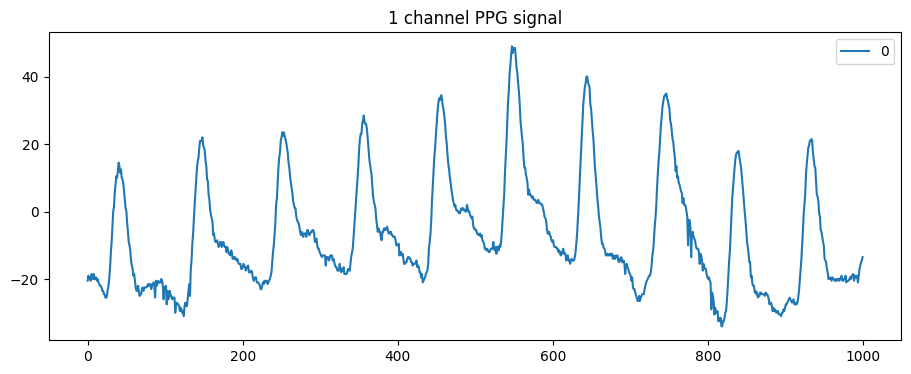

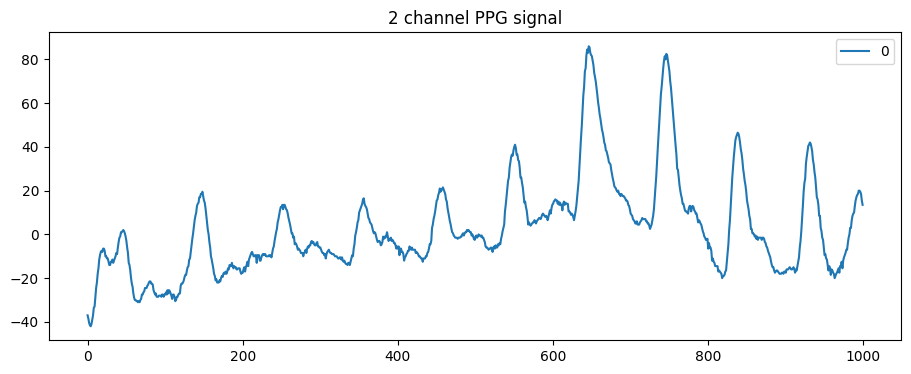

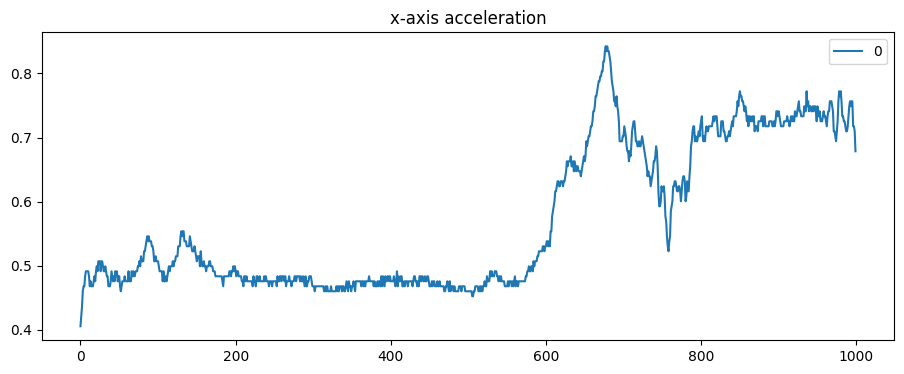

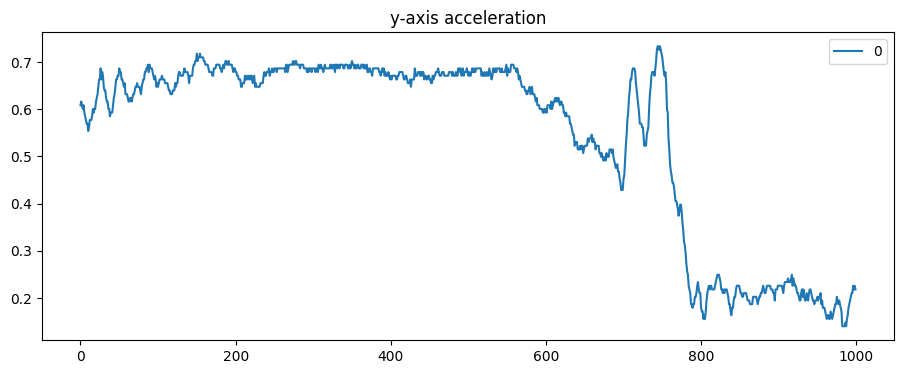

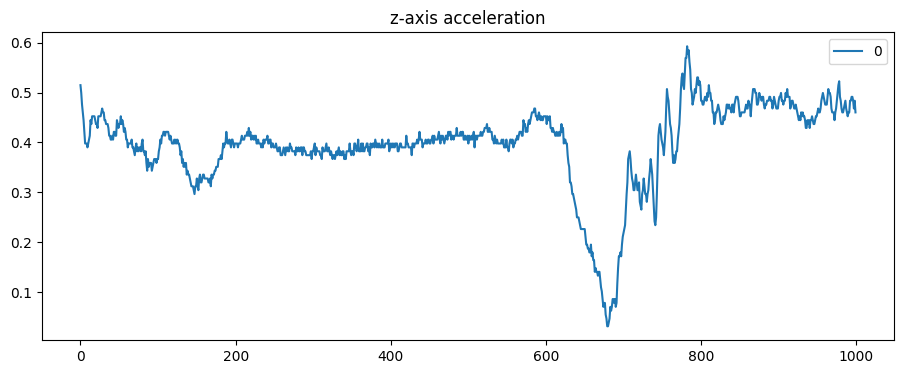

In [23]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='1 channel PPG signal')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='2 channel PPG signal')
pd.DataFrame(input_data.features[1, 2, :]).plot(title='x-axis acceleration')
pd.DataFrame(input_data.features[1, 3, :]).plot(title='y-axis acceleration')
pd.DataFrame(input_data.features[1, 4, :]).plot(title='z-axis acceleration')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [24]:
metric_dict = {}
input_data = init_input_data(train_data[0], train_data[1], task='regression')
val_data = init_input_data(test_data[0], test_data[1], task='regression')
with IndustrialModels():
    for model in model_dict.keys():
        print(f'Current_model - {model}')
        pipeline = model_dict[model].build()
        pipeline.fit(input_data)
        features = pipeline.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric_dict.update({model: metric})

Current_model - regression_with_statistical_features
Current_model - regression_pca_with_statistical_features
Current_model - regression_with_reccurence_features
Current_model - regression_pca_with_reccurence_features
Current_model - regression_with_topological_features
Current_model - regression_pca_with_topological_features


At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [25]:
df_baseline = pd.concat([x for x in metric_dict.values()],axis=1)
df_baseline.columns = list(metric_dict.keys())
df_baseline = df_baseline.T
df_baseline

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score
regression_with_statistical_features,-7.468266,8182.085460,90.454881,77.120185,70.302458,-1.601039,495.729209,-1.868315
regression_pca_with_statistical_features,-0.242950,1200.944853,34.654651,27.737209,24.373313,0.025087,69.736723,-0.031624
regression_with_reccurence_features,-3.709123,4549.980971,67.453547,49.104460,36.759664,-1.752046,471.482557,-0.826332
regression_pca_with_reccurence_features,-0.165477,1126.090636,33.557274,26.919195,23.618249,0.265126,81.004285,-0.001200
regression_with_topological_features,-0.412142,1364.419221,36.938046,29.380255,24.066633,-0.048299,76.914691,-0.092734
regression_pca_with_topological_features,-0.412142,1364.419221,36.938046,29.380255,24.066633,-0.048299,76.914691,-0.092734


In [26]:
best_baseline = df_baseline.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Could it be done better? Tuning approach

In [27]:
metric_dict = {}
with IndustrialModels():
    for model in model_dict.keys():
        print(f'Current_model - {model}')
        pipeline = model_dict[model].build()
        tuned_pipeline = tuning_industrial_pipelines(pipeline, tuning_params, train_data)
        tuned_pipeline.fit(input_data)
        features = tuned_pipeline.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric = metric.T
        metric.columns = metric.columns.values
        metric['model_params'] = metric['model_params'] = str(
            {node: node.parameters for node in tuned_pipeline.graph_description['nodes']})
        metric_dict.update({model: metric})

Current_model - regression_with_statistical_features
2023-10-12 17:08:06,755 - DataSourceSplitter - Stratificated splitting of data is disabled.
2023-10-12 17:08:06,757 - DataSourceSplitter - Hold out validation is applied.
2023-10-12 17:08:06,771 - SequentialTuner - Hyperparameters optimization start: estimation of metric for initial graph
2023-10-12 17:13:01,150 - SequentialTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [ridge, quantile_extractor]}
ridge - {}
quantile_extractor - {'window_size': 5} 
Initial metric: [76.599]
  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]2023-10-12 17:13:01,155 - build_posterior_wrapper took 0.000990 seconds
2023-10-12 17:13:01,156 - TPE using 0 trials
  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]2023-10-12 17:16:42,855 - build_posterior_wrapper took 0.000000 seconds
2023-10-12 17:16:42,856 - TPE using 0 trials
  7%|▋         | 1/15 [03:40<51:26, 220.47s/trial, best loss: 56.71853002270995]
2023-10-12 17:20:23,322 - Sequenti

In [28]:
df_tuned = pd.concat([x for x in metric_dict.values()],axis=0).T
df_tuned.columns = list(metric_dict.keys())
df_tuned.T.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score,model_params
regression_pca_with_statistical_features,-0.267307,1224.479283,34.99256,28.002211,24.469579,0.01928,70.151608,-0.041481,"{ridge: {'alpha': 3.6182614123314063}, pca: {'..."
regression_pca_with_topological_features,-0.358628,1312.713985,36.231395,29.108821,24.356167,-0.093163,76.709922,-0.082638,"{ridge: {'alpha': 8.456083606865826}, pca: {'s..."
regression_with_topological_features,-0.445373,1396.527196,37.370138,29.633046,23.844611,-0.068693,78.899169,-0.102136,"{ridge: {'alpha': 2.0374680133907237}, pca: {'..."
regression_pca_with_reccurence_features,-0.824586,1762.925179,41.987203,33.59318,28.397834,0.050515,112.092017,-0.249424,"{ridge: {'alpha': 1.6319331955058072}, pca: {'..."
regression_with_statistical_features,-4.418449,5235.335498,72.355618,48.349462,36.018301,-4.253361,632.934648,-0.798252,"{ridge: {'alpha': 4.447241082992835}, quantile..."
regression_with_reccurence_features,-5.360063,6145.128132,78.390868,44.090572,26.029369,-5.186325,628.270569,-0.639852,"{ridge: {'alpha': 0.5841302173429871}, recurre..."


In [29]:
df_tuned.T.sort_values('root_mean_squared_error:')['model_params'].iloc[0]

"{ridge: {'alpha': 3.6182614123314063}, pca: {'svd_solver': 'full', 'n_components': 0.47009543669720244}, quantile_extractor: {'window_size': 24, 'stride': 8}}"

In [30]:
best_tuned = df_tuned.T.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Even better? AutoML approach

In [31]:
metric_dict = {}
runs = 5
for run in range(runs):
    with IndustrialModels():
        auto_ml = PipelineBuilder().add_node('quantile_extractor',
                                              params={'window_size': 5}).add_node('fedot_regr',
                                                                             params={'timeout': 10,'logging_level':30}).build()
        auto_ml.fit(input_data)
        features = auto_ml.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric = metric.T
        metric.columns = metric.columns.values
        metric['model_params'] = metric['model_params'] = str({node:node.parameters for node in auto_ml.graph_description['nodes']})
        metric_dict.update({f'run_number - {run}':metric})

2023-10-13 01:25:55,375 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 428.0 MiB, max: 1009.2 MiB
2023-10-13 01:25:55,389 - ApiComposer - Initial pipeline was fitted in 1444.9 sec.
2023-10-13 01:25:55,391 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2023-10-13 01:25:55,397 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 10 min. Set of candidate models: ['rfr', 'ridge', 'scaling', 'normalization', 'pca', 'catboostreg', 'xgbreg', 'svr', 'dtreg', 'treg', 'knnreg', 'fast_ica', 'kernel_pca', 'isolation_forest_reg', 'rfe_lin_reg', 'rfe_non_lin_reg'].
2023-10-13 01:25:55,400 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 1444.859073 sec.
2023-10-13 01:25:55,713 - ApiComposer - Model generation finished
2023-10-13 01:25:55,803 - FEDOT logger - Already fitted initial pipeline is used
2023-10-13 01:25:55,804 - FEDOT logge

In [32]:
df_automl = pd.concat([x for x in metric_dict.values()],axis=0).T
df_automl.columns = list(metric_dict.keys())
df_automl = df_automl.T
df_automl.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score,model_params
run_number - 0,-0.214571,1173.525382,34.256757,28.322523,26.695466,0.140885,82.363357,-0.053394,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 1,-0.214571,1173.525382,34.256757,28.322523,26.695466,0.140885,82.363357,-0.053394,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 2,-0.214571,1173.525382,34.256757,28.322523,26.695466,0.140885,82.363357,-0.053394,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 3,-0.214571,1173.525382,34.256757,28.322523,26.695466,0.140885,82.363357,-0.053394,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 4,-0.214571,1173.525382,34.256757,28.322523,26.695466,0.140885,82.363357,-0.053394,"{fedot_regr: {'timeout': 10, 'logging_level': ..."


## Compare with State of Art (SOTA) models

In [ ]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')

In [ ]:
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)
df['Fedot_Industrial_baseline'] = best_baseline
df['Fedot_Industrial_tuned'] = best_tuned
df['Fedot_Industrial_AutoML'] = 0
df['Fedot_Industrial_AutoML'].iloc[0] = df_automl['root_mean_squared_error:'].min()
df['Fedot_Industrial_AutoML'].iloc[1] = df_automl['root_mean_squared_error:'].max()
df['Fedot_Industrial_AutoML'].iloc[2] = df_automl['root_mean_squared_error:'].mean()
df = df.T

In [33]:
df.sort_values('min')

NameError: name 'df' is not defined

In [ ]:
df.sort_values('max')

In [ ]:
df.sort_values('average')